# Data

# Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Brain')

In [ ]:

import zipfile
import numpy as np
import tensorflow as tf
import scipy

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow.keras.backend as K
from tensorflow.keras.losses import mse
from tensorflow.keras.layers import Conv3D, Activation, Add, UpSampling3D, Lambda, Dense, Concatenate, Dropout
from tensorflow.keras.layers import Input, Reshape, Flatten, Dropout, SpatialDropout3D, BatchNormalization,  MaxPooling3D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import applications

## Data Reading

In [ ]:
def read_paths(directory, folder_name):
    """Read magnetic resonance images MRI paths"""
    #Create empty dictionary
    paths_dic = dict()
    # Loop over the diseases folders
    for fol in folder_name:
        folder = os.path.join(directory, fol)
        # Create a list with every MRI per disease
        paths = [os.path.join(folder, x) for x in os.listdir(folder) if x.endswith(tuple([".nii."]))]
        # Append list to dictionary
        paths_dic[fol] = paths[0:int(len(paths))]
    return paths_dic

In [ ]:
intensities_dir = os.path.join(os.getcwd(),"Intensities")
segmentation_dir = os.path.join(os.getcwd(),"Segmentation")
diseases = ['AZ','Healthy','MCI','MS','PD']

intensities_path = read_paths(intensities_dir, diseases)
segmentation_path = read_paths(segmentation_dir, diseases)

for d, s in segmentation_path.items():
    print('total number of images of ' + d + ' patients is: ' + str(len(s)))

total number of images of AZ patients is: 60
total number of images of Healthy patients is: 150
total number of images of MCI patients is: 30
total number of images of MS patients is: 30
total number of images of PD patients is: 60


## Data Pre-processing

In [ ]:
import nibabel as nib
from scipy import ndimage


def read_nifti(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan

def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti(path)
    return volume

def processed_mri(paths_dic):
    """Read each MRI and process it"""
    #Create empty dict
    scans_dict = dict()
    #Loop over each disease and path
    for d, s in paths_dic.items():
        #list of processed scans
        scans = [process_scan(i) for i in s]
        #Append processed scans to each disease
        scans_dict[d] = scans
    return scans_dict

def processed_labels(paths_dic):
    """Read each MRI and label it according to each disease"""
    #Create empty dict
    labels_dict = dict()
    #Set initial label
    index = 0
    #loop over each disease and path
    for d, s in paths_dic.items():
        #List of labels
        labels = [index for i in range(len(s))]
        #Update index
        index = index + 1
        #Append labels
        labels_dict[d] = labels
    return labels_dict

In [ ]:
intensities_scans = processed_mri(intensities_path)
segmentation_scans = processed_mri(segmentation_path)
labels_scans = processed_labels(segmentation_path)

In [ ]:
epi_img_data = segmentation_scans['MS'][29]

In [ ]:
epi_img_data.shape

(91, 109, 91)

Text(0.5, 0.98, 'Center slices for EPI image')

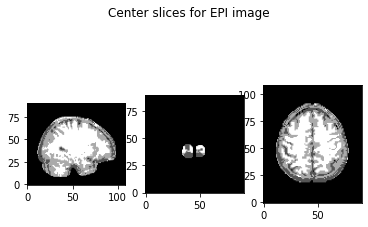

In [ ]:
import matplotlib.pyplot as plt
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

slice_0 = epi_img_data[60, :, :]
slice_1 = epi_img_data[:, 100, :]
slice_2 = epi_img_data[:, :, 60]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for EPI image")  

## Data Splitting

In [ ]:
from sklearn.model_selection import train_test_split
def split_data(scans, categorical = False):
    
    data = dict()
    
    total_train = []
    total_test = []
    total_val = []
    
    diseases = [d  for  d in scans.keys()]
    for d in diseases:
        scans_disease = scans[d]
        s_train, s_test = train_test_split(scans_disease, test_size = 0.30, random_state = 42)
        s_val, s_test = train_test_split(s_test, test_size = 0.5, random_state = 42)
        
        total_train += s_train
        total_test += s_test
        total_val += s_val

    if not categorical:
        data['train'] = np.array(total_train, dtype="float32")
        data['test'] = np.array(total_test, dtype="float32")
        data['val'] = np.array(total_val, dtype="float32")
    else:
        data['train'] = keras.utils.to_categorical(np.array(total_train))
        data['test'] = keras.utils.to_categorical(np.array(total_test))
        data['val'] = np.array(keras.utils.to_categorical(total_val))
    
    return data

In [ ]:
intensities_data = split_data(intensities_scans)
segmentation_data = split_data(segmentation_scans)
labels_data = split_data(labels_scans, True)

In [ ]:
import random

@tf.function
def flip(volume):
    """Rotate the volume by a few degrees"""
    # define flipping planes
    dims = [True, False]
    # pick a plane at random
    plane = random.choice(dims)
    # flip volume
    if plane:
        volume = volume[::-1,:,:]
    else:
        volume = volume[:,::-1,:]
    return volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume_dict = dict()
    
    for k, v in volume.items():
        volume_dict[k] = flip(volume[k])
    return volume_dict, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    return volume, label

## Data Loaders

In [ ]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices(({"input_1" : intensities_data['train'], "input_2" : segmentation_data['train']}, labels_data['train']))
validation_loader = tf.data.Dataset.from_tensor_slices(({"input_1" : intensities_data['val'], "input_2" : segmentation_data['val']}, labels_data['val']))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(segmentation_data['train']))
   # .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(segmentation_data['val']))
   # .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

# 3D CNN Models


## 3D CNN Alzheimer's Divergent L4

3D CNN Design for the Classification of Alzheimer’s Disease Using Brain MRI and PET


In [ ]:
def cnnAZClassification(width = 91, height = 109, depth = 91):
    
    input_x = Input((width, height, depth, 1))
    input_y = keras.Input((width, height, depth, 1))

    x = Conv3D(filters=64, kernel_size=(3,3,3) , strides=(1, 1, 1), activation='relu')(input_x)
    x = MaxPooling3D(pool_size=2, strides=(1,1,1))(x)
    x = BatchNormalization()(x)
    
    x = Conv3D(filters=64, kernel_size=(5,5,5) , strides=(1, 1, 1), activation='relu')(x)
    x = MaxPooling3D(pool_size=2, strides=(2,2,2))(x)
    x = BatchNormalization()(x)

    x = Conv3D(filters=64, kernel_size=(7,7,7) , strides=(1, 1, 1), activation='relu')(x)
    x = MaxPooling3D(pool_size=2, strides=(3,3,3))(x)
    x = BatchNormalization()(x)
    
    x = Conv3D(filters=64, kernel_size=(9,9,9) , strides=(1, 1, 1), activation='relu')(x)
    x = MaxPooling3D(pool_size=2, strides=(4,4,4))(x)
    x = BatchNormalization()(x)
    
    x = Flatten()(x)
    
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(units=128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    y = Conv3D(filters=64, kernel_size=(3,3,3) , strides=(1, 1, 1), activation='relu')(input_y)
    y = MaxPooling3D(pool_size=2, strides=(1,1,1))(y)
    y = BatchNormalization()(y)
    
    y = Conv3D(filters=64, kernel_size=(5,5,5) , strides=(1, 1, 1), activation='relu')(y)
    y = MaxPooling3D(pool_size=2, strides=(2,2,2))(y)
    y = BatchNormalization()(y)

    y = Conv3D(filters=64, kernel_size=(7,7,7) , strides=(1, 1, 1), activation='relu')(y)
    y = MaxPooling3D(pool_size=2, strides=(3,3,3))(y)
    y = BatchNormalization()(y)

    
    y = Conv3D(filters=64, kernel_size=(9,9,9) , strides=(1, 1, 1), activation='relu')(y)
    y = MaxPooling3D(pool_size=2, strides=(4,4,4))(y)
    y = BatchNormalization()(y)
    
    y = Flatten()(y)

    y = layers.Dense(units=512, activation="relu")(y)
    y = layers.Dropout(0.5)(y)
    
    y = layers.Dense(units=128, activation="relu")(y)
    y = layers.Dropout(0.5)(y)

    concat = Concatenate(axis=-1)([x, y])
    concat = Dense(units=512, activation="relu")(concat)
    concat = Dropout(0.5)(concat)
    
    outputs = layers.Dense(units=5, activation="softmax")(concat)
    
    model = Model(inputs= [input_x, input_y] , outputs= outputs, name = '3DCNN-Seg-AZ1')
    return model

# Build model.
model = cnnAZClassification(width=91, height=109, depth=91)
model.summary()

Model: "3DCNN-Seg-AZ1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 91, 109, 91, 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 91, 109, 91, 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 89, 107, 89,  1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_4 (Conv3D)               (None, 89, 107, 89,  1792        input_2[0][0]                    
______________________________________________________________________________________

In [ ]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3DCNN-Segmentation-AZ1.h5", save_best_only=True
)

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"]
)

In [ ]:
epochs = 100
val = model.fit( train_dataset, validation_data= validation_dataset, epochs=epochs, shuffle=True,verbose=2,  callbacks= [checkpoint_cb])

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(val.history[metric])
    ax[i].plot(val.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])


In [ ]:
model.load_weights("3DCNN-Segmentation-AZ1.h5")
print(model.evaluate(validation_dataset))

24/24 [==============================] - 19s 432ms/step - loss: 0.5825 - acc: 0.7951
[0.6107235550880432, 0.7708333134651184]


In [ ]:
prediction = model.predict([np.expand_dims(intensities_data['test'][50], axis=0), np.expand_dims(segmentation_data['test'][50], axis = 0)])[0]
scores = prediction

class_names = ["AZ", "Healthy", 'MCI','MS','PD']
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that MRI scan is %s"
        % ((100 * score), name)
    )

This model is 1.66 percent confident that MRI scan is AZ
This model is 17.04 percent confident that MRI scan is Healthy
This model is 4.51 percent confident that MRI scan is MCI
This model is 0.47 percent confident that MRI scan is MS
This model is 76.32 percent confident that MRI scan is PD


In [ ]:
predictions = []
for scan in range(len(intensities_data['test'])):
  prediction = model.predict([np.expand_dims(intensities_data['test'][scan], axis=0), np.expand_dims(segmentation_data['test'][scan], axis = 0)])[0]
  predictions.append(prediction)

In [ ]:
predictions = np.array(predictions)

In [ ]:
y_real = np.argmax(labels_data['test'], axis=1)

In [ ]:
y_pred = np.argmax(predictions, axis=1)

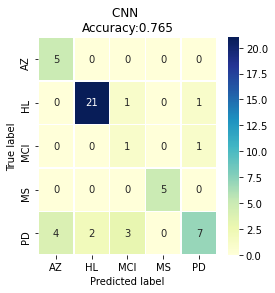

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
cm = confusion_matrix(y_pred, y_real)

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['AZ','HL','MCI','MS','PD'], 
                     columns = ['AZ','HL','MCI','MS','PD'])

plt.figure(figsize = (4,4))
sns.heatmap(cm_df, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('CNN \nAccuracy:{0:.3f}'.format(accuracy_score(y_pred, y_real)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_pred, y_real))

              precision    recall  f1-score   support

           0       0.56      1.00      0.71         5
           1       0.91      0.91      0.91        23
           2       0.20      0.50      0.29         2
           3       1.00      1.00      1.00         5
           4       0.78      0.44      0.56        16

    accuracy                           0.76        51
   macro avg       0.69      0.77      0.69        51
weighted avg       0.82      0.76      0.77        51



## 3D CNN for Brain Tumor Classification
Deep Multi-Scale 3D Convolutional Neural Network (CNN) for MRI Gliomas Brain Tumor Classification.

In [ ]:
def cnnBTClassification(width = 91 , height = 109, depth = 91):
    
    input_x = Input((width, height, depth, 1))

    x = Conv3D(filters=32, kernel_size=(3,3,3) , strides=(2, 2, 2), activation='relu')(input_x)
    x = BatchNormalization()(x)
    
    x = Conv3D(filters=64, kernel_size=(3,3,3) , strides=(1, 1, 1), activation='relu')(x)
    x = MaxPooling3D(pool_size=1)(x)
    x = BatchNormalization()(x)
    
    x = Conv3D(filters=128, kernel_size=(3,3,3) , strides=(2, 2, 2), activation='relu')(x)
    x = MaxPooling3D(pool_size=1)(x)
    x = BatchNormalization()(x)
    
    x = Conv3D(filters=256, kernel_size=(3,3,3) , strides=(1, 1, 1), activation='relu')(x)
    x = MaxPooling3D(pool_size=1)(x)
    x = BatchNormalization()(x)
    
    x = Conv3D(filters=256, kernel_size=(3,3,3) , strides=(2, 2, 2), activation='relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv3D(filters=128, kernel_size=(3,3,3) , strides=(1, 1, 1), activation='relu')(x)
    x = UpSampling3D(size=1)(x)
    x = BatchNormalization()(x)
    
    x = Conv3D(filters=64, kernel_size=(3,3,3) , strides=(2, 2,2), activation='relu')(x)
    x = UpSampling3D(size=1)(x)
    x = BatchNormalization()(x)
    
    x = Conv3D(filters=32, kernel_size=(3,3,3) , strides=(1, 1, 1), activation='relu')(x)
    x = Flatten()(x)

    x = Dense(units=256, activation="relu")(x)
    x = Dense(units=256, activation="relu")(x)

    input_y = Input((width, height, depth, 1))

    y = Conv3D(filters=32, kernel_size=(3,3,3) , strides=(2, 2, 2), activation='relu')(input_y)
    y = BatchNormalization()(y)
    
    y = Conv3D(filters=64, kernel_size=(3,3,3) , strides=(1, 1, 1), activation='relu')(y)
    y = MaxPooling3D(pool_size=1)(y)
    y = BatchNormalization()(y)
    
    y = Conv3D(filters=128, kernel_size=(3,3,3) , strides=(2, 2, 2), activation='relu')(y)
    y = MaxPooling3D(pool_size=1)(y)
    y = BatchNormalization()(y)
    
    y = Conv3D(filters=256, kernel_size=(3,3,3) , strides=(1, 1, 1), activation='relu')(y)
    y = MaxPooling3D(pool_size=1)(y)
    y = BatchNormalization()(y)
    
    y = Conv3D(filters=256, kernel_size=(3,3,3) , strides=(2, 2, 2), activation='relu')(y)
    y = BatchNormalization()(y)
    
    y = Conv3D(filters=128, kernel_size=(3,3,3) , strides=(1, 1, 1), activation='relu')(y)
    y = UpSampling3D(size=1)(y)
    y = BatchNormalization()(y)
    
    y = Conv3D(filters=64, kernel_size=(3,3,3) , strides=(2, 2,2), activation='relu')(y)
    y = UpSampling3D(size=1)(y)
    y = BatchNormalization()(y)
    
    y = Conv3D(filters=32, kernel_size=(3,3,3) , strides=(1, 1, 1), activation='relu')(y)
    y = Flatten()(y)

    y = Dense(units=256, activation="relu")(y)
    y = Dense(units=256, activation="relu")(y)

    concat = Concatenate(axis=-1)([x, y])
    concat = Dense(units=512, activation="relu")(concat)
    concat = Dropout(0.5)(concat)
    outputs = layers.Dense(units=5, activation="softmax")(concat)
    
    #model = Model(inputs= input_x , outputs= outputs)
    model = Model(inputs= [input_x, input_y] , outputs= outputs, name = '3DCNN-Seg-BT')
    
    return model

model = cnnBTClassification()
model.summary()

Model: "3DCNN-Seg-BT"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 91, 109, 91, 0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 91, 109, 91, 0                                            
__________________________________________________________________________________________________
conv3d_128 (Conv3D)             (None, 45, 54, 45, 3 896         input_17[0][0]                   
__________________________________________________________________________________________________
conv3d_136 (Conv3D)             (None, 45, 54, 45, 3 896         input_18[0][0]                   
_______________________________________________________________________________________

In [ ]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3DCNN-Segmentation-BTCla.h5", save_best_only=True
)

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"]
)

In [ ]:
epochs = 100
val = model.fit( train_dataset, validation_data= validation_dataset, epochs=epochs, shuffle=True,verbose=2,  callbacks= [checkpoint_cb])

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(val.history[metric])
    ax[i].plot(val.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])


In [ ]:
model.load_weights("3DCNN-Segmentation-BTCla.h5")
print(model.evaluate(validation_dataset))

48/48 [==============================] - 1s 23ms/step - loss: 0.7290 - acc: 0.7500
[0.7290156483650208, 0.75]


In [ ]:
prediction = model.predict([np.expand_dims(intensities_data['test'][0], axis=0), np.expand_dims(segmentation_data['test'][0], axis = 0)])[0]
scores = prediction

class_names = ["HL", "MS", 'AZ','MCI','PD']
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that MRI scan is %s"
        % ((100 * score), name)
    )

This model is 7.47 percent confident that MRI scan is HL
This model is 92.25 percent confident that MRI scan is MS
This model is 0.12 percent confident that MRI scan is AZ
This model is 0.00 percent confident that MRI scan is MCI
This model is 0.16 percent confident that MRI scan is PD


In [ ]:
predictions = []
for scan in range(len(intensities_data['test'])):
  prediction = model.predict([np.expand_dims(intensities_data['test'][scan], axis=0), np.expand_dims(segmentation_data['test'][scan], axis = 0)])[0]
  predictions.append(prediction)

In [ ]:
predictions = np.array(predictions)

In [ ]:
y_real = np.argmax(labels_data['test'], axis=1)

In [ ]:
y_pred = np.argmax(predictions, axis=1)

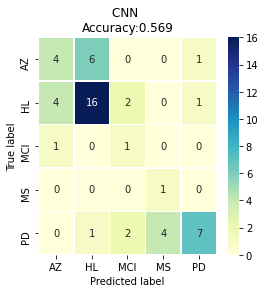

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
cm = confusion_matrix(y_pred, y_real)

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['AZ','HL','MCI','MS','PD'], 
                     columns = ['AZ','HL','MCI','MS','PD'])

plt.figure(figsize = (4,4))
sns.heatmap(cm_df, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('CNN \nAccuracy:{0:.3f}'.format(accuracy_score(y_pred, y_real)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## 3D CNN Alzheimer's stage classification
Predicting Alzheimer's Disease with 3D Convolutional Neural Networks


In [ ]:
def cnnAZClassification_Dos(width = 91, height = 109, depth = 91):
    
    input_x = Input((width, height, depth, 1))
    input_y = Input((width, height, depth, 1))

    x = Conv3D(filters=64, kernel_size=(3,3,3) , strides=(1, 1, 1), activation='relu')(input_x)
    x = MaxPooling3D(pool_size=2)(x)
    
    x = Conv3D(filters=128, kernel_size=(3,3,3) , strides=(1, 1, 1), activation='relu')(x)
    x = Conv3D(filters=256, kernel_size=(3,3,3) , strides=(1, 1, 1), activation='relu')(x)
    x = MaxPooling3D(pool_size=2)(x)

    x = Conv3D(filters=324, kernel_size=(3,3,3) , strides=(1, 1, 1), activation='relu')(x)
    x = Conv3D(filters=324, kernel_size=(3,3,3) , strides=(1, 1, 1), activation='relu')(x)
    x = MaxPooling3D(pool_size=2)(x)
    
    x = Conv3D(filters=512, kernel_size=(3,3,3) , strides=(1, 1, 1), activation='relu')(x)
    x = MaxPooling3D(pool_size=2)(x)
    
    x = layers.Dense(units=256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    x = Flatten()(x)

    y = Conv3D(filters=64, kernel_size=(3,3,3) , strides=(1, 1, 1), activation='relu')(input_y)
    y = MaxPooling3D(pool_size=2)(y)
    
    y = Conv3D(filters=128, kernel_size=(3,3,3) , strides=(1, 1, 1), activation='relu')(y)
    y = Conv3D(filters=256, kernel_size=(3,3,3) , strides=(1, 1, 1), activation='relu')(y)
    y = MaxPooling3D(pool_size=2)(y)

    y = Conv3D(filters=324, kernel_size=(3,3,3) , strides=(1, 1, 1), activation='relu')(y)
    y = Conv3D(filters=324, kernel_size=(3,3,3) , strides=(1, 1, 1), activation='relu')(y)
    y = MaxPooling3D(pool_size=2)(y)
    
    y = Conv3D(filters=512, kernel_size=(3,3,3) , strides=(1, 1, 1), activation='relu')(y)
    y = MaxPooling3D(pool_size=2)(y)
    
    y = layers.Dense(units=256, activation="relu")(y)
    y = layers.Dropout(0.3)(y)

    y = Flatten()(y)

    concat = Concatenate(axis=-1)([x, y])
    concat = Dense(units=256, activation="relu")(concat)
    concat = Dropout(0.5)(concat)

    outputs = layers.Dense(units=5, activation="softmax")(concat)
    
    model = Model(inputs= [input_x, input_y] , outputs= outputs, name = '3DCNN-Seg-AZ2')
    
    return model

model = cnnAZClassification_Dos()
model.summary()

Model: "3DCNN-Seg-AZ2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 91, 109, 91, 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 91, 109, 91, 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 89, 107, 89,  1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_6 (Conv3D)               (None, 89, 107, 89,  1792        input_2[0][0]                    
______________________________________________________________________________________

In [ ]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3DCNN-Segmentation-AZ2.h5", save_best_only=True
)

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"]
)

In [ ]:
epochs = 100
val = model.fit( train_dataset, validation_data= validation_dataset, epochs=epochs, shuffle=True,verbose=2, callbacks= [checkpoint_cb])

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(val.history[metric])
    ax[i].plot(val.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
model.load_weights("3DCNN-Segmentation-AZ2.h5")
print(model.evaluate(validation_dataset))

48/48 [==============================] - 4s 92ms/step - loss: 1.0099 - acc: 0.6250
[1.0098985433578491, 0.625]


In [ ]:
prediction = model.predict([np.expand_dims(intensities_data['test'][0], axis=0), np.expand_dims(segmentation_data['test'][0], axis = 0)])[0]
scores = prediction

class_names = ["HL", "MS", 'AZ','MCI','PD']
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that MRI scan is %s"
        % ((100 * score), name)
    )

This model is 29.10 percent confident that MRI scan is HL
This model is 45.77 percent confident that MRI scan is MS
This model is 7.64 percent confident that MRI scan is AZ
This model is 1.52 percent confident that MRI scan is MCI
This model is 15.98 percent confident that MRI scan is PD


In [ ]:
predictions = []
for scan in range(len(intensities_data['test'])):
  prediction = model.predict([np.expand_dims(intensities_data['test'][scan], axis=0), np.expand_dims(segmentation_data['test'][scan], axis = 0)])[0]
  predictions.append(prediction)

In [ ]:
predictions = np.array(predictions)
y_real = np.argmax(labels_data['test'], axis=1)
y_pred = np.argmax(predictions, axis=1)

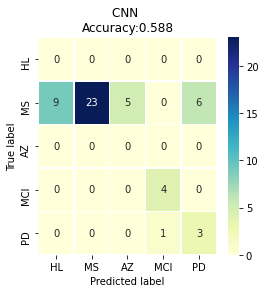

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
cm = confusion_matrix(y_pred, y_real)

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['HL','MS','AZ', 'MCI', 'PD'], 
                     columns = ['HL','MS','AZ', 'MCI', 'PD'])

plt.figure(figsize = (4,4))
sns.heatmap(cm_df, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('CNN \nAccuracy:{0:.3f}'.format(accuracy_score(y_pred, y_real)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## 3D CNN Alzheimer's fMRI
Spatiotemporal feature extraction and classification
of Alzheimer’s disease using deep learning 3D-CNN
for fMRI data

In [ ]:
def cnnAZClassification_Tres(width = 91, height = 109, depth = 91):
    
    input_x = Input((width, height, depth, 1))

    x = Conv3D(filters=64, kernel_size=(1,1,1) , strides=(1, 1, 1), activation='relu')(input_x)
    x = MaxPooling3D(pool_size=2)(x)
    x = BatchNormalization()(x)
    
    x = Conv3D(filters=128, kernel_size=(1,1,1) , strides=(1, 1, 1), activation='relu')(x)
    x = layers.Dropout(0.8)(x)
    x = BatchNormalization()(x)
    
    x = Conv3D(filters=32, kernel_size=(5,5,5) , strides=(1, 1, 1), activation='relu')(x)
    x = MaxPooling3D(pool_size=2)(x)
    
    x = Conv3D(filters=64, kernel_size=(3,3,3) , strides=(1, 1, 1), activation='relu')(input_x)
    x = MaxPooling3D(pool_size=2)(x)
    
    x = Conv3D(filters=128, kernel_size=(3,3,3) , strides=(1, 1, 1), activation='relu')(x)
    x = layers.Dropout(0.8)(x)
    x = MaxPooling3D(pool_size=2)(x)
    x = BatchNormalization()(x)
    
    x = layers.Dense(units=256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
        
    x = layers.Dense(units=32, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    x = Flatten()(x)

    input_y = Input((width, height, depth, 1))

    y = Conv3D(filters=64, kernel_size=(1,1,1) , strides=(1, 1, 1), activation='relu')(input_y)
    y = MaxPooling3D(pool_size=2)(y)
    y = BatchNormalization()(y)
    
    y = Conv3D(filters=128, kernel_size=(1,1,1) , strides=(1, 1, 1), activation='relu')(y)
    y = Dropout(0.8)(y)
    y = BatchNormalization()(y)
    
    y = Conv3D(filters=32, kernel_size=(5,5,5) , strides=(1, 1, 1), activation='relu')(y)
    y = MaxPooling3D(pool_size=2)(y)
    
    y = Conv3D(filters=64, kernel_size=(3,3,3) , strides=(1, 1, 1), activation='relu')(input_y)
    y = MaxPooling3D(pool_size=2)(y)
    
    y = Conv3D(filters=128, kernel_size=(3,3,3) , strides=(1, 1, 1), activation='relu')(y)
    y = Dropout(0.8)(y)
    y = MaxPooling3D(pool_size=2)(y)
    y = BatchNormalization()(y)
    
    y = layers.Dense(units=256, activation="relu")(y)
    y = layers.Dropout(0.5)(y)
        
    y = layers.Dense(units=32, activation="relu")(y)
    y = layers.Dropout(0.5)(y)

    y = Flatten()(y)

    concat = Concatenate(axis=-1)([x, y])
    concat = Dense(units=512, activation="relu")(concat)
    concat = Dropout(0.5)(concat)

    outputs = layers.Dense(units=5, activation="softmax")(concat)
    
    model = Model(inputs= [input_x, input_y] , outputs= outputs, name = '3DCNN-Seg-AZ3')
    
    return model

model = cnnAZClassification_Tres()
model.summary()

Model: "3DCNN-Seg-AZ3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 91, 109, 91, 0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 91, 109, 91, 0                                            
__________________________________________________________________________________________________
conv3d_85 (Conv3D)              (None, 89, 107, 89,  1792        input_17[0][0]                   
__________________________________________________________________________________________________
conv3d_90 (Conv3D)              (None, 89, 107, 89,  1792        input_18[0][0]                   
______________________________________________________________________________________

In [ ]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3DCNN-Segmentation-AZ2.h5", save_best_only=True
)

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"]
)

In [ ]:
epochs = 100
val = model.fit( train_dataset, validation_data= validation_dataset, epochs=epochs, shuffle=True,verbose=2, callbacks= [checkpoint_cb])

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(val.history[metric])
    ax[i].plot(val.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
model.load_weights("3DCNN-Segmentation-AZ2.h5")
print(model.evaluate(validation_dataset))

48/48 [==============================] - 2s 35ms/step - loss: 1.1515 - acc: 0.5625
[1.1514883041381836, 0.5625]


In [ ]:
predictions = []
for scan in range(len(intensities_data['test'])):
  prediction = model.predict([np.expand_dims(intensities_data['test'][scan], axis=0), np.expand_dims(segmentation_data['test'][scan], axis = 0)])[0]
  predictions.append(prediction)

In [ ]:
predictions = np.array(predictions)
y_real = np.argmax(labels_data['test'], axis=1)
y_pred = np.argmax(predictions, axis=1)

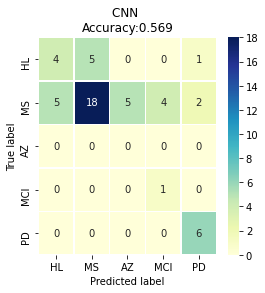

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
cm = confusion_matrix(y_pred, y_real)

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['HL','MS','AZ', 'MCI', 'PD'], 
                     columns = ['HL','MS','AZ', 'MCI', 'PD'])

plt.figure(figsize = (4,4))
sns.heatmap(cm_df, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('CNN \nAccuracy:{0:.3f}'.format(accuracy_score(y_pred, y_real)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Bayesian 3D CNN

## Bayesian Kl Divergence - FlipOut

In [ ]:
group_lib = os.path.join(os.getcwd(), "group_norm.py")
open(group_lib)

<_io.TextIOWrapper name='/content/drive/MyDrive/Brain/group_norm.py' mode='r' encoding='UTF-8'>

In [ ]:
import tensorflow_probability as tfp
from group_norm import GroupNormalization

In [ ]:
import tensorflow_addons as tfa

In [ ]:
kl_divergence_function = lambda q, p, _: tfp.distributions.kl_divergence(q, p) / tf.cast(231, dtype=tf.float32)

In [ ]:
tf.keras.backend.clear_session()

def cnnAZClassification(width = 91, height = 109, depth = 91):
   
    input_x = Input((width, height, depth, 1))
    input_y = keras.Input((width, height, depth, 1))

    x = tfp.layers.Convolution3DFlipout(filters=64, kernel_size=(3,3,3) , strides=(1, 1, 1), activation=tf.nn.relu , kernel_divergence_fn=kl_divergence_function)(input_x)
    x = MaxPooling3D(pool_size=2, strides=(1,1,1))(x)
    x = GroupNormalization()(x)
   
    x = tfp.layers.Convolution3DFlipout(filters=64, kernel_size=(5,5,5) , strides=(1, 1, 1), activation=tf.nn.relu , kernel_divergence_fn=kl_divergence_function)(x)
    x = MaxPooling3D(pool_size=2, strides=(2,2,2))(x)
    x = GroupNormalization()(x)

    x = tfp.layers.Convolution3DFlipout(filters=64, kernel_size=(7,7,7) , strides=(1, 1, 1), activation=tf.nn.relu , kernel_divergence_fn=kl_divergence_function)(x)
    x = MaxPooling3D(pool_size=2, strides=(3,3,3))(x)
    x = GroupNormalization()(x)
   
    x = tfp.layers.Convolution3DFlipout(filters=64, kernel_size=(9,9,9) , strides=(1, 1, 1), activation=tf.nn.relu , kernel_divergence_fn=kl_divergence_function)(x)
    x = MaxPooling3D(pool_size=2, strides=(4,4,4))(x)
    x = GroupNormalization()(x)
   
    x = Flatten()(x)
   
    x = tfp.layers.DenseFlipout(units=512, activation=tf.nn.relu, kernel_divergence_fn=kl_divergence_function)(x)
    x = layers.Dropout(0.5)(x)
   
    x = tfp.layers.DenseFlipout(units=128, activation=tf.nn.relu, kernel_divergence_fn=kl_divergence_function)(x)
    x = layers.Dropout(0.5)(x)

    y = tfp.layers.Convolution3DFlipout(filters=64, kernel_size=(3,3,3) , strides=(1, 1, 1), activation=tf.nn.relu , kernel_divergence_fn=kl_divergence_function)(input_y)
    y = MaxPooling3D(pool_size=2, strides=(1,1,1))(y)
    y = GroupNormalization()(y)
   
    y = tfp.layers.Convolution3DFlipout(filters=64, kernel_size=(5,5,5) , strides=(1, 1, 1), activation=tf.nn.relu , kernel_divergence_fn=kl_divergence_function)(y)
    y = MaxPooling3D(pool_size=2, strides=(2,2,2))(y)
    y = GroupNormalization()(y)

    y = tfp.layers.Convolution3DFlipout(filters=64, kernel_size=(7,7,7) , strides=(1, 1, 1), activation=tf.nn.relu , kernel_divergence_fn=kl_divergence_function)(y)
    y = MaxPooling3D(pool_size=2, strides=(3,3,3))(y)
    y = GroupNormalization()(y)
   
    y = tfp.layers.Convolution3DFlipout(filters=64, kernel_size=(9,9,9) , strides=(1, 1, 1), activation=tf.nn.relu , kernel_divergence_fn=kl_divergence_function)(y)
    y = MaxPooling3D(pool_size=2, strides=(4,4,4))(y)
    y = GroupNormalization()(y)
   
    y = Flatten()(x)
   
    y = tfp.layers.DenseFlipout(units=512, activation=tf.nn.relu, kernel_divergence_fn=kl_divergence_function)(y)
    y = layers.Dropout(0.5)(y)
   
    y = tfp.layers.DenseFlipout(units=128, activation=tf.nn.relu, kernel_divergence_fn=kl_divergence_function)(y)
    y = layers.Dropout(0.5)(y)

    concat = Concatenate(axis=-1)([x, y])
    concat = tfp.layers.DenseFlipout(units=512, activation=tf.nn.relu, kernel_divergence_fn=kl_divergence_function)(concat)
    concat = Dropout(0.5)(concat)
   
    outputs = tfp.layers.DenseFlipout(units=5, activation=tf.nn.softmax,kernel_divergence_fn=kl_divergence_function)(concat)
   
    model = Model(inputs= [input_x, input_y] , outputs= outputs)
    return model

# Build model.
model = cnnAZClassification(width=91, height=109, depth=91)
model.summary()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 91, 109, 91, 0                                            
__________________________________________________________________________________________________
conv3d_flipout (Conv3DFlipout)  (None, 89, 107, 89,  3520        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling3d (MaxPooling3D)    (None, 88, 106, 88,  0           conv3d_flipout[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 88, 106, 88,  256         max_pooling3d[0][0]              
______________________________________________________________________________________________

In [ ]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3DCNN-Segmentation-AZ1-Bayesian.h5", save_best_only=True
)

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"]
)

In [ ]:
epochs = 100
val = model.fit( train_dataset, validation_data= validation_dataset, epochs=epochs, shuffle=True,verbose=2, callbacks= [checkpoint_cb])

## Bayesian A Priori Distribution - FlipOut

In [ ]:
group_lib = os.path.join(os.getcwd(), "group_norm.py")
open(group_lib)

<_io.TextIOWrapper name='/content/drive/My Drive/Brain/group_norm.py' mode='r' encoding='UTF-8'>

In [ ]:
import tensorflow_probability as tfp
from group_norm import GroupNormalization

In [ ]:
def normal_prior(prior_std):
    """Defines normal distribution prior for Bayesian neural network."""

    def prior_fn(dtype, shape, name, trainable, add_variable_fn):
        tfd = tfp.distributions
        dist = tfd.Normal(loc=tf.zeros(shape, dtype),
                          scale=dtype.as_numpy_dtype((prior_std)))
        batch_ndims = tf.size(input=dist.batch_shape_tensor())
        return tfd.Independent(dist, reinterpreted_batch_ndims=batch_ndims)

    return prior_fn

In [ ]:
prior_std = 1
prior_fn = normal_prior(prior_std)

In [ ]:
def cnnAZClassification(width = 91, height = 109, depth = 91):
    
    input_x = Input((width, height, depth, 1))
    input_y = keras.Input((width, height, depth, 1))

    x = tfp.layers.Convolution3DFlipout(filters=64, kernel_size=(3,3,3) , strides=(1, 1, 1), activation=tf.nn.relu , kernel_prior_fn= prior_fn)(input_x)
    x = MaxPooling3D(pool_size=2, strides=(1,1,1))(x)
    x = GroupNormalization()(x)
    
    x = tfp.layers.Convolution3DFlipout(filters=64, kernel_size=(5,5,5) , strides=(1, 1, 1), activation=tf.nn.relu , kernel_prior_fn= prior_fn)(x)
    x = MaxPooling3D(pool_size=2, strides=(2,2,2))(x)
    x = GroupNormalization()(x)

    x = tfp.layers.Convolution3DFlipout(filters=64, kernel_size=(7,7,7) , strides=(1, 1, 1), activation=tf.nn.relu , kernel_prior_fn= prior_fn)(x)
    x = MaxPooling3D(pool_size=2, strides=(3,3,3))(x)
    x = GroupNormalization()(x)
    
    x = tfp.layers.Convolution3DFlipout(filters=64, kernel_size=(9,9,9) , strides=(1, 1, 1), activation=tf.nn.relu , kernel_prior_fn= prior_fn)(x)
    x = MaxPooling3D(pool_size=2, strides=(4,4,4))(x)
    x = GroupNormalization()(x)
    
    x = Flatten()(x)
    
    x = tfp.layers.DenseFlipout(units=512, activation=tf.nn.relu, kernel_prior_fn= prior_fn)(x)
    x = layers.Dropout(0.5)(x)
    
    x = tfp.layers.DenseFlipout(units=128, activation=tf.nn.relu, kernel_prior_fn= prior_fn)(x)
    x = layers.Dropout(0.5)(x)

    y = tfp.layers.Convolution3DFlipout(filters=64, kernel_size=(3,3,3) , strides=(1, 1, 1), activation=tf.nn.relu , kernel_prior_fn= prior_fn)(input_y)
    y = MaxPooling3D(pool_size=2, strides=(1,1,1))(y)
    y = GroupNormalization()(y)
    
    y = tfp.layers.Convolution3DFlipout(filters=64, kernel_size=(5,5,5) , strides=(1, 1, 1), activation=tf.nn.relu , kernel_prior_fn= prior_fn)(y)
    y = MaxPooling3D(pool_size=2, strides=(2,2,2))(y)
    y = GroupNormalization()(y)

    y = tfp.layers.Convolution3DFlipout(filters=64, kernel_size=(7,7,7) , strides=(1, 1, 1), activation=tf.nn.relu , kernel_prior_fn= prior_fn)(y)
    y = MaxPooling3D(pool_size=2, strides=(3,3,3))(y)
    y = GroupNormalization()(y)
    
    y = tfp.layers.Convolution3DFlipout(filters=64, kernel_size=(9,9,9) , strides=(1, 1, 1), activation=tf.nn.relu , kernel_prior_fn= prior_fn)(y)
    y = MaxPooling3D(pool_size=2, strides=(4,4,4))(y)
    y = GroupNormalization()(y)
    
    y = Flatten()(y)
    
    y = tfp.layers.DenseFlipout(units=512, activation=tf.nn.relu, kernel_prior_fn= prior_fn)(y)
    y = layers.Dropout(0.5)(y)
    
    y = tfp.layers.DenseFlipout(units=128, activation=tf.nn.relu, kernel_prior_fn= prior_fn)(y)
    y = layers.Dropout(0.5)(y)

    concat = Concatenate(axis=-1)([x, y])
    concat = tfp.layers.DenseFlipout(units=512, activation=tf.nn.relu, kernel_prior_fn= prior_fn)(concat)
    concat = Dropout(0.5)(concat)
    
    outputs = tfp.layers.DenseFlipout(units=5, activation=tf.nn.softmax, kernel_prior_fn= prior_fn)(concat)
    
    model = Model(inputs= [input_x, input_y] , outputs= outputs)
    return model

# Build model.
model = cnnAZClassification(width=91, height=109, depth=91)
model.summary()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 91, 109, 91, 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 91, 109, 91, 0                                            
__________________________________________________________________________________________________
conv3d_flipout (Conv3DFlipout)  (None, 89, 107, 89,  3520        input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_flipout_4 (Conv3DFlipout (None, 89, 107, 89,  3520        input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3DCNN-Segmentation-AZ1-Bayesian-prior.h5", save_best_only=True
)

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"]
)

In [ ]:
epochs = 100
val = model.fit( train_dataset, validation_data= validation_dataset, epochs=epochs, shuffle=True,verbose=2, callbacks= [checkpoint_cb])

## Bayesian Kl/A priori - Reparametrization

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfpl = tfp.layers

### Gaussian Process
# Layers weights distribution priors
kernel_prior_fn = tfpl.default_multivariate_normal_fn
# layers bias distribution priors
bias_prior_fn = tfpl.default_multivariate_normal_fn

### Normal Distribution
# Layers weights distribution posteriors
kernel_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False)
# layers bias distribution posteriors
bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False)

### Kullback-Leibler divergence
divergence_fn = lambda q,p,_:tfd.kl_divergence(q,p)/231
kernel_divergence_fn = divergence_fn
bias_divergence_fn = divergence_fn

In [ ]:
def cnnAZClassification(width = 91, height = 109, depth = 91):
    
    input_x = Input((width, height, depth, 1))
    input_y = keras.Input((width, height, depth, 1))

    x = tfpl.Convolution3DReparameterization(filters=64, kernel_size=(3,3,3) , strides=(1, 1, 1), activation='relu',
                                           kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                           kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           kernel_divergence_fn = divergence_fn,
                                           bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                           bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           bias_divergence_fn = divergence_fn)(input_x)
    x = MaxPooling3D(pool_size=2, strides=(1,1,1))(x)
    
    x = Conv3D(filters=64, kernel_size=(5,5,5) , strides=(1, 1, 1), activation='relu')(x)
    x = MaxPooling3D(pool_size=2, strides=(2,2,2))(x)

    x = Conv3D(filters=64, kernel_size=(7,7,7) , strides=(1, 1, 1), activation='relu')(x)
    x = MaxPooling3D(pool_size=2, strides=(3,3,3))(x)
    
    x = Conv3D(filters=64, kernel_size=(9,9,9) , strides=(1, 1, 1), activation='relu')(x)
    x = MaxPooling3D(pool_size=2, strides=(4,4,4))(x)
    
    x = Flatten()(x)
    
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(units=128, activation="relu")(x)
    x = layers.Dropout(0.2)(x)


    y = Conv3D(filters=64, kernel_size=(3,3,3) , strides=(1, 1, 1), activation='relu')(input_y)
    y = MaxPooling3D(pool_size=2, strides=(1,1,1))(y)
    
    y = Conv3D(filters=64, kernel_size=(5,5,5) , strides=(1, 1, 1), activation='relu')(y)
    y = MaxPooling3D(pool_size=2, strides=(2,2,2))(y)

    y = Conv3D(filters=64, kernel_size=(7,7,7) , strides=(1, 1, 1), activation='relu')(y)
    y = MaxPooling3D(pool_size=2, strides=(3,3,3))(y)
    
    y = Conv3D(filters=64, kernel_size=(9,9,9) , strides=(1, 1, 1), activation='relu')(y)
    y = MaxPooling3D(pool_size=2, strides=(4,4,4))(y)
    
    y = Flatten()(y)

    y = layers.Dense(units=512, activation="relu")(y)
    y = layers.Dropout(0.2)(y)
    y = layers.Dense(units=128, activation="relu")(y)
    y = layers.Dropout(0.2)(y)

    concat = Concatenate(axis=-1)([x, y])
    concat = Dense(units=512, activation="relu")(concat)
    concat = Dropout(0.2)(concat)

    
    outputs = tfpl.DenseReparameterization(units=tfpl.OneHotCategorical.params_size(5), activation=None,
                                    kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                    kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    kernel_divergence_fn = divergence_fn,
                                    bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                    bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    bias_divergence_fn = divergence_fn
                                )(concat
                                  )
    outputs = tfpl.OneHotCategorical(5)(outputs)
    
    model = Model(inputs= [input_x, input_y] , outputs= outputs)
    return model

# Build model.
model = cnnAZClassification(width=91, height=109, depth=91)
model.summary()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 91, 109, 91, 0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 91, 109, 91, 0                                            
__________________________________________________________________________________________________
conv3d_reparameterization_1 (Co (None, 89, 107, 89,  3584        input_7[0][0]                    
__________________________________________________________________________________________________
conv3d_26 (Conv3D)              (None, 89, 107, 89,  1792        input_8[0][0]                    
____________________________________________________________________________________________

In [ ]:
def negative_log_likelihood(y_true, y_pred):
    return -y_pred.log_prob(y_true)

In [ ]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3DCNN-Seg-Bayesian-Repara-AZ1.h5", save_best_only=True
)

model.compile(
    loss= negative_log_likelihood,
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["accuracy"]
)

In [ ]:
epochs = 100
model.fit(train_dataset, validation_data = validation_dataset, epochs= epochs, shuffle = True , verbose = 2 , callbacks = [checkpoint_cb])

In [ ]:
model.load_weights("3DCNN-Seg-Bayesian-Repara-AZ1.h5")
print(model.evaluate(validation_dataset))

24/24 [==============================] - 11s 431ms/step - loss: 0.5509 - acc: 0.8125
[0.5509052276611328, 0.8125]


In [ ]:
predictions = []
for scan in range(len(intensities_data['val'])):
  prediction = model.predict([np.expand_dims(intensities_data['val'][scan], axis=0), np.expand_dims(segmentation_data['val'][scan], axis = 0)])[0]
  predictions.append(prediction)

In [ ]:
predictions = np.array(predictions)
y_real = np.argmax(labels_data['val'], axis=1)
y_pred = np.argmax(predictions, axis=1)

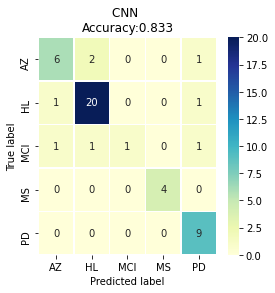

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
cm = confusion_matrix(y_real, y_pred)

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['AZ','HL','MCI','MS','PD'], 
                     columns = ['AZ','HL','MCI','MS','PD'])

plt.figure(figsize = (4,4))
sns.heatmap(cm_df, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('CNN \nAccuracy:{0:.3f}'.format(accuracy_score(y_real, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

In [ ]:
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)
# f1 SCORE
F1 = (2*(TP))/(2*(TP)+FN+FP)

In [ ]:
TNR

array([0.94871795, 0.88461538, 1.        , 1.        , 0.92307692])

In [ ]:
from sklearn.metrics import classification_report, cohen_kappa_score
print(classification_report(y_pred, y_real))

              precision    recall  f1-score   support

           0       0.67      0.75      0.71         8
           1       0.91      0.87      0.89        23
           2       0.25      1.00      0.40         1
           3       1.00      1.00      1.00         4
           4       1.00      0.75      0.86        12

    accuracy                           0.83        48
   macro avg       0.77      0.87      0.77        48
weighted avg       0.89      0.83      0.85        48



In [ ]:
cohen_kappa_score(y_real, y_pred)

0.7326732673267327

In [ ]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [ ]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(labels_data['val'][:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(labels_data['val'].ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(5):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= 5

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

fig, axs = plt.subplots(1, 2,figsize=(12,5))

# Plot all ROC curves
plt.figure(figsize=(8,8))

axs[1].plot(fpr["micro"], tpr["micro"],
          label='micro-average (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
          color='gray', linestyle='--', linewidth=2)

axs[1].plot(fpr["macro"], tpr["macro"],
        label='macro-average (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='black', linestyle='--', linewidth=2)

colors = cycle(['gray','gray','gray','black','black'])
linestyles = ['dotted','dashed','solid', 'solid','dashed']
diseases = ['AZ', 'Healthy','MCI','MS','PD']
for i, color, lw, d in zip(range(5), colors, linestyles, diseases):
    axs[0].plot(fpr[i], tpr[i], color=color, linestyle=lw,
             label='{0} (area = {1:0.2f})'
             ''.format(d, roc_auc[i]))

axs[0].plot([0, 1], [0, 1], 'k--', lw=1)
axs[0].set_title('ROC per disease')
axs[0].axis(xmin = 0.0,  xmax= 1.0 , ymin = 0.0 , ymax = 1.05)
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[1].plot([0, 1], [0, 1], 'k--', lw=1)
axs[1].set_title('ROC micro - macro')
axs[1].axis(xmin = 0.0,  xmax= 1.0 , ymin = 0.0 , ymax = 1.05)
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
#plt.title('Some extension of Receiver operating characteristic to multi-class')
axs[0].legend(loc="lower right")
axs[1].legend(loc="lower right")
plt.show()

### Feature Maps

In [ ]:
for layer in model.layers:
  print(layer)

In [ ]:
img = 36
layer = 2
filter = 14

In [ ]:
print(model.layers[layer])
model_lay = Model(inputs=model.inputs, outputs=model.layers[layer].output)
feature_maps = model_lay.predict([np.expand_dims(intensities_data['val'][img], axis=0), 
                             np.expand_dims(segmentation_data['val'][img], axis = 0)])

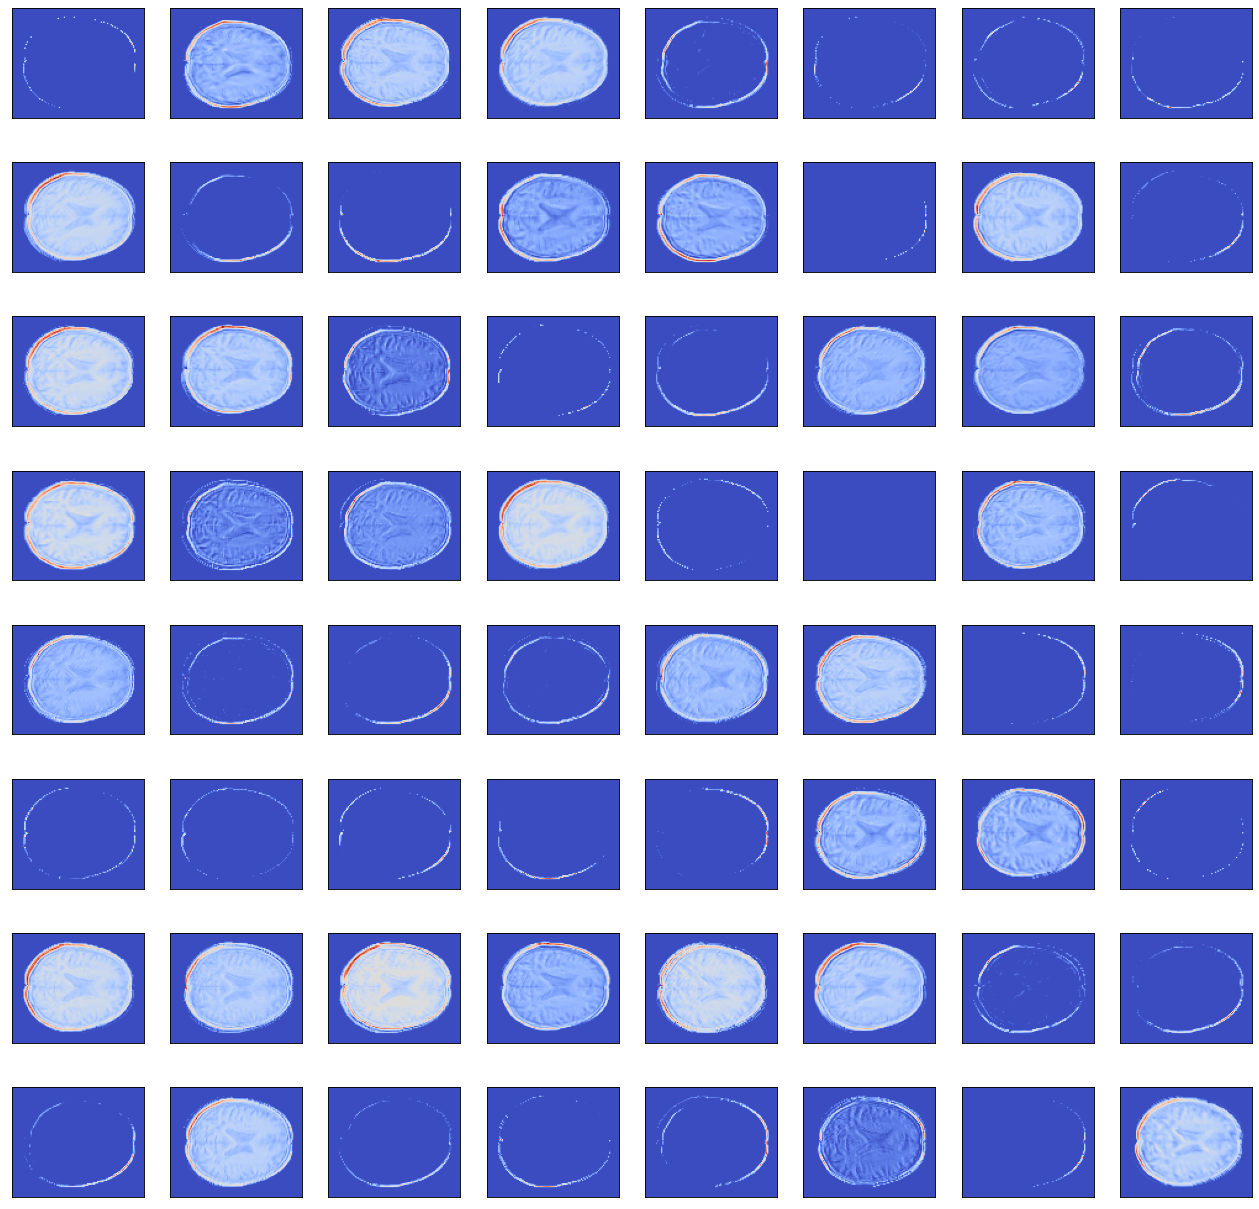

In [ ]:
from matplotlib.pyplot import figure
from matplotlib import pyplot
figure(num=None, figsize=(20,20), dpi=80, facecolor='w', edgecolor='k')
square = 8
ix = 1
for _ in range(square):
  for _ in range(square):
    # specify subplot and turn of axis
    ax = pyplot.subplot(square, square, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    a = feature_maps[0,:, :, 46, ix-1]
    #a = np.ma.masked_where(a <= 0, a)

    plt.imshow(a, cmap='coolwarm')
    ix += 1
# show the figure
pyplot.show()

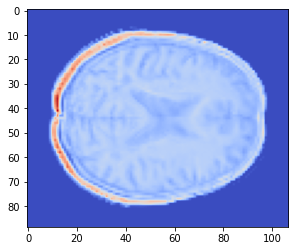

In [ ]:
##selecting a random feature map (position 27)
a = feature_maps[0,:, :, 46, filter]
plt.imshow(a, cmap='coolwarm')

Text(0.5, 1.0, 'Center slices for EPI image')

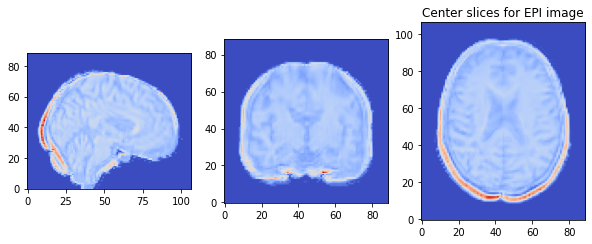

In [ ]:
## showing the 3 dimensions of the selected 
import matplotlib.pyplot as plt
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices), figsize = (10,10))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="coolwarm", origin="lower")

slice_0 = feature_maps[0,46, :, :,filter]
slice_1 = feature_maps[0,:, 55, :,filter]
slice_2 = feature_maps[0,:, :, 46,filter]
show_slices([slice_0, slice_1, slice_2])
plt.title("Center slices for EPI image")  

In [ ]:
layer = 3
print(model.layers[layer])
model_lay = Model(inputs=model.inputs, outputs=model.layers[layer].output)
feature_maps = model_lay.predict([np.expand_dims(intensities_data['val'][img], axis=0), 
                             np.expand_dims(segmentation_data['val'][img], axis = 0)])

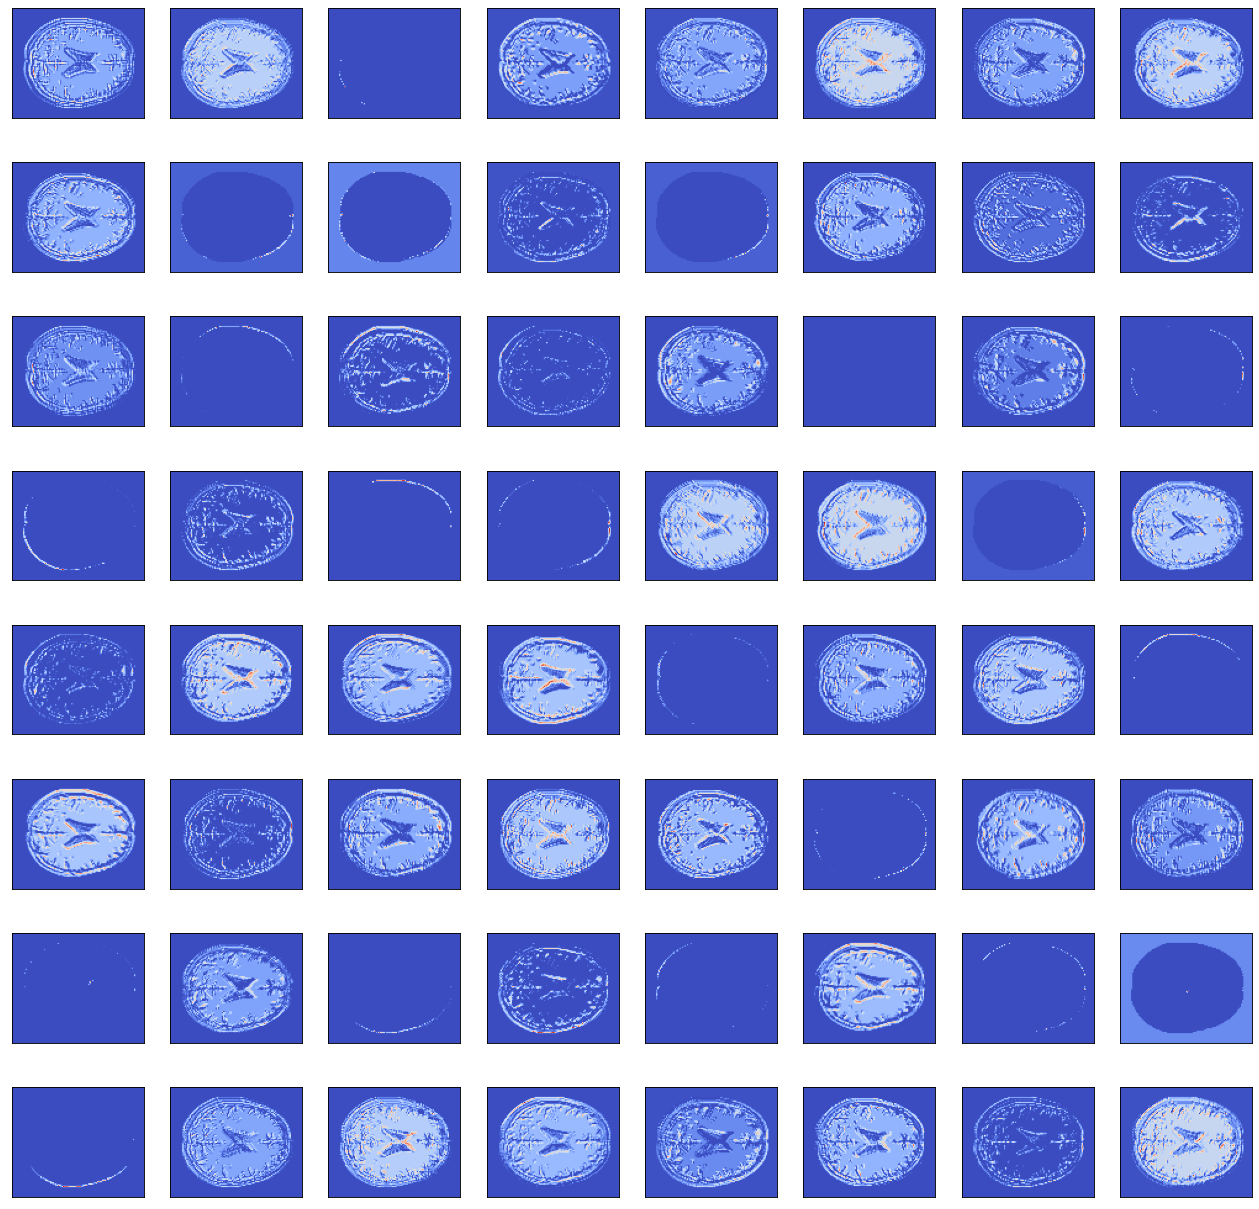

In [ ]:
from matplotlib.pyplot import figure
from matplotlib import pyplot
figure(num=None, figsize=(20,20), dpi=80, facecolor='w', edgecolor='k')
square = 8
ix = 1
for _ in range(square):
  for _ in range(square):
    # specify subplot and turn of axis
    ax = pyplot.subplot(square, square, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    a = feature_maps[0,:, :, 46, ix-1]
    #a = np.ma.masked_where(a <= 0, a)

    plt.imshow(a, cmap='coolwarm')
    ix += 1
# show the figure
pyplot.show()

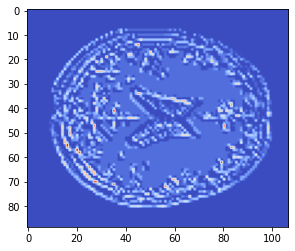

In [ ]:
a = feature_maps[0,:, :, 46, filter]
plt.imshow(a, cmap='coolwarm')

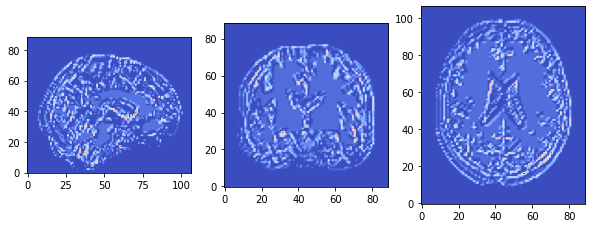

In [ ]:
import matplotlib.pyplot as plt
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices), figsize = (10,10))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="coolwarm", origin="lower")

slice_0 = feature_maps[0,46, :, :,filter]
slice_1 = feature_maps[0,:, 55, :,filter]
slice_2 = feature_maps[0,:, :, 46,filter]
show_slices([slice_0, slice_1, slice_2])

### Bayesian inference


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)
##7, 19, 33 , 36 , 46
images_test = [i for i in range(48)]
iterations = 100

In [ ]:
def probabilities(test_mri, iterations):
  y_probas = []
  y_means = []
  y_stds = []
  y_reals = []

  for img in range(len(test_mri)):
    probs = np.stack([model([np.expand_dims(intensities_data['val'][test_mri[img]], axis=0), 
                             np.expand_dims(segmentation_data['val'][test_mri[img]], axis = 0)], training=True)
                     for sample in range(iterations)])
    mean = probs.mean(axis = 0)
    std = probs.std(axis = 0)
    real = np.argmax(labels_data['val'][test_mri[img]], axis = -1)


    y_probas.append(probs)
    y_means.append(mean)
    y_stds.append(std)
    y_reals.append(real)
  
  return y_probas, y_means, y_stds, y_reals

In [ ]:
y_probas , y_means , y_stds, y_reals = probabilities(images_test, iterations)

In [ ]:
def prediction_status(predictions, real_value):
  if len(predictions) == 1:
    if (predictions[0] == real_value):
      status = 'Correct'
    else:
      status = 'Incorrect'
  else:
    status = 'Uncertain'

  return status

In [ ]:
from matplotlib import colors

def plot_uncertainities(probabilities, true_ground, iterations):

  fig, axs = plt.subplots(1, 5, sharey=True,figsize=(12,2))
  diseases = ['AZ','HL','MCI','MS','PD']

  fig.text(x=0.1, y=1.05, s= 'Disease: ' + diseases[true_ground] , fontsize = 12)

  predicted = []
  for d in range(0,len(diseases)):
    probs = [np.log(probabilities[i,0][d]) for i in range(iterations)]
    prob = np.percentile(np.exp(probs), 50)
    stand = np.std(np.exp(probs))
    N, bins, patches = axs[d].hist(probs, bins = 8, weights= np.ones(len(probs)) / len(probs) , color = 'lightgray')
    axs[d].set_title( diseases[d] + " (" + str(round(prob,2)) + ")")

    if (prob > 0.5):
      axs[d].set_title( diseases[d] + " (" + str(round(prob,2)) + '±' + str(round(stand,2)) + ")")
      predicted.append(d)
      fracs = N / N.max()
      norm = colors.Normalize(fracs.min(), fracs.max())

      for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.coolwarm(norm(thisfrac))
        thispatch.set_facecolor(color)

  status = prediction_status(predicted, true_ground)
  fig.text(x=0.1, y=-0.1, s= status , fontsize = 12)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


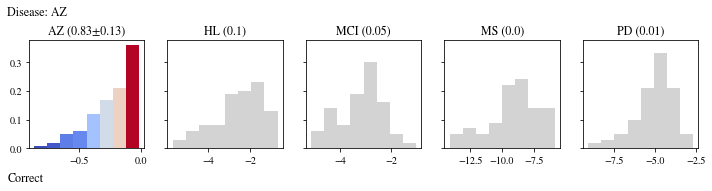

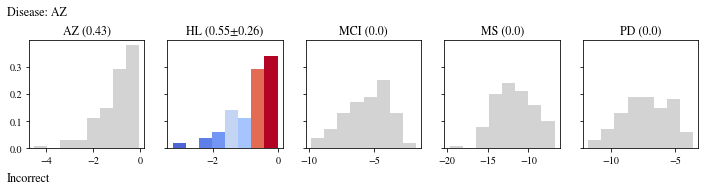

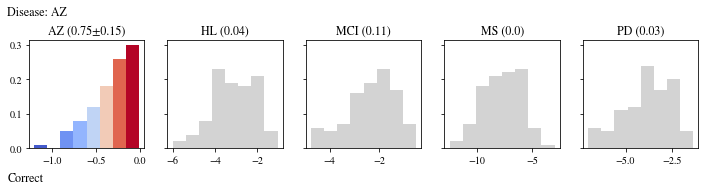

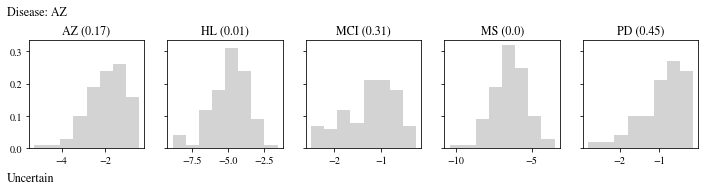

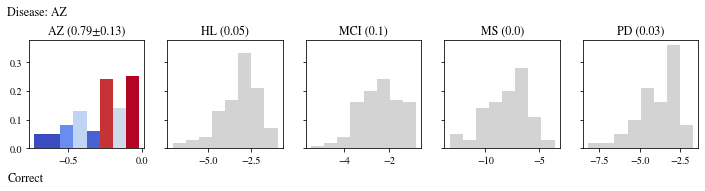

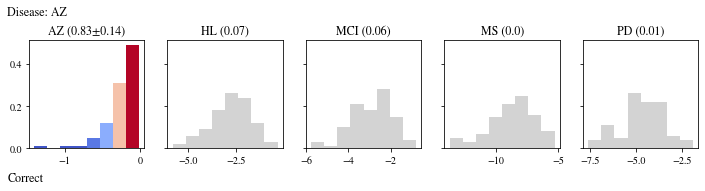

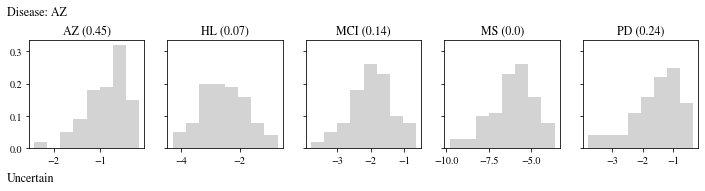

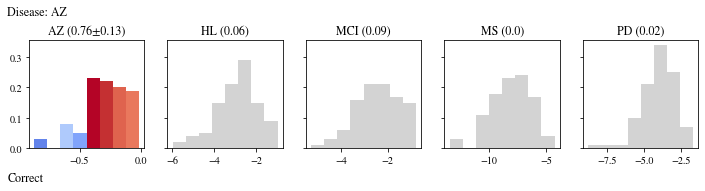

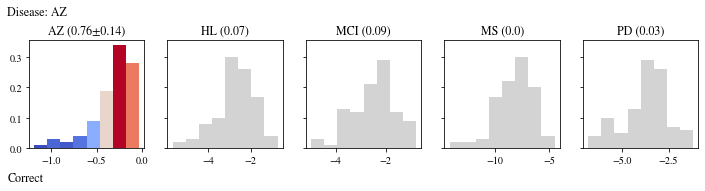

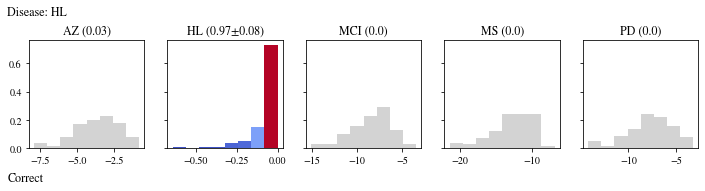

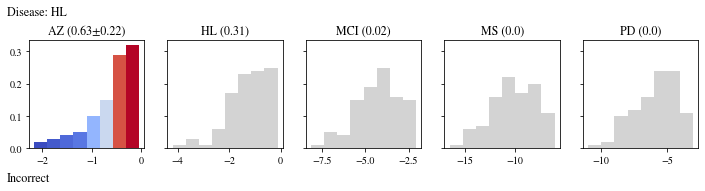

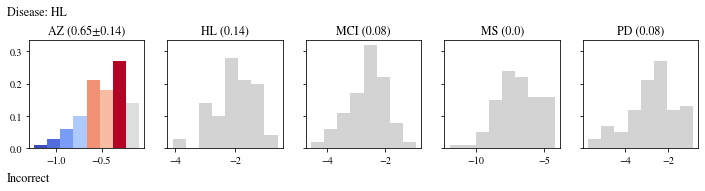

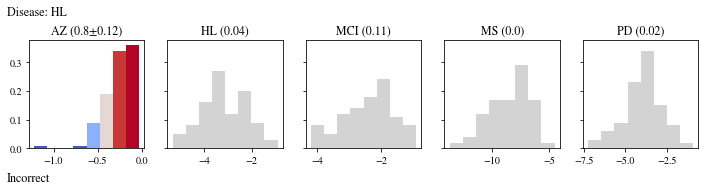

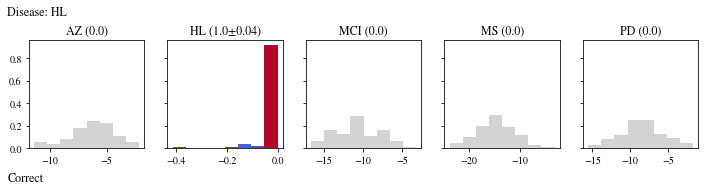

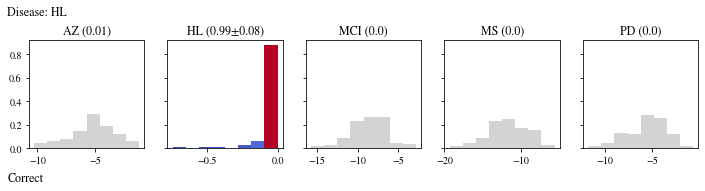

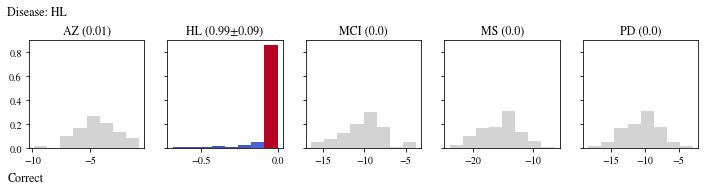

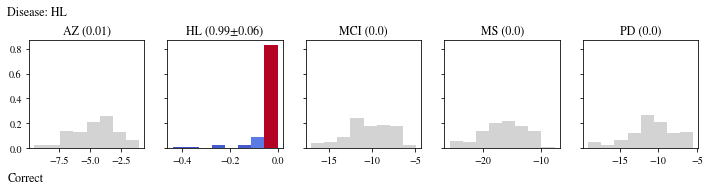

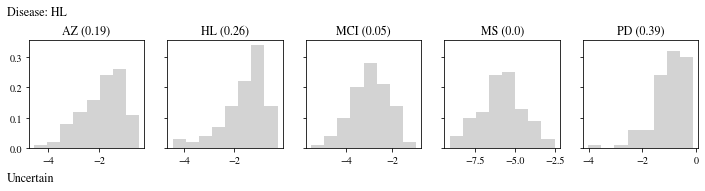

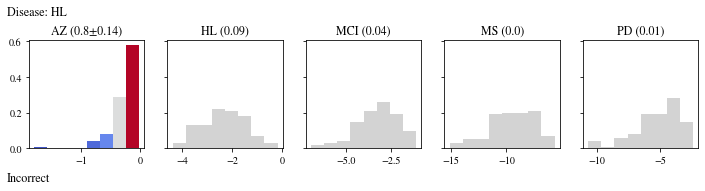

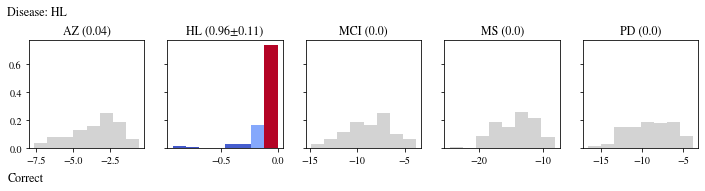

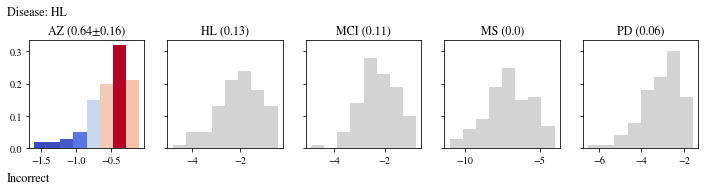

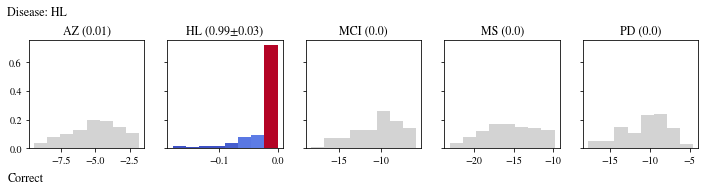

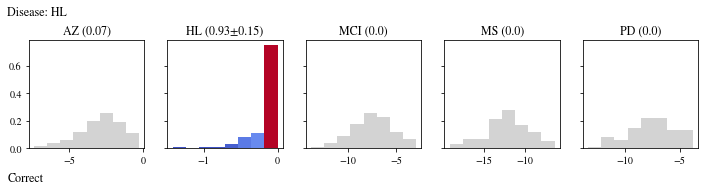

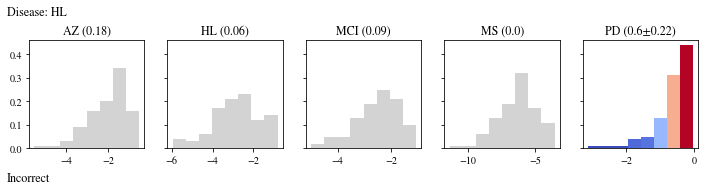

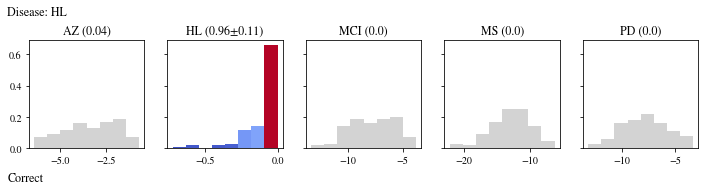

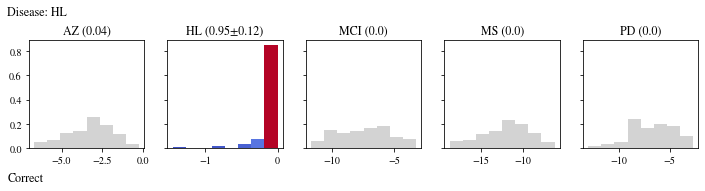

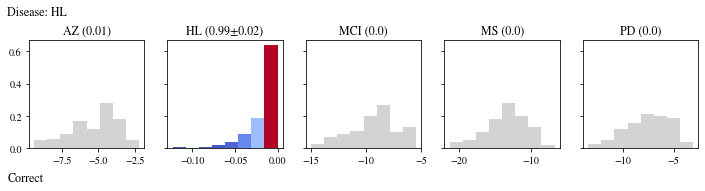

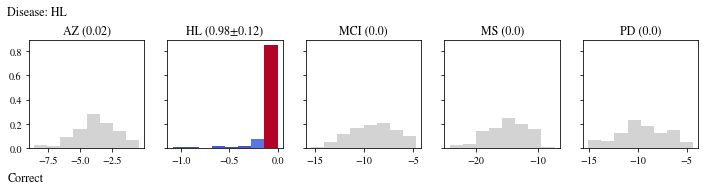

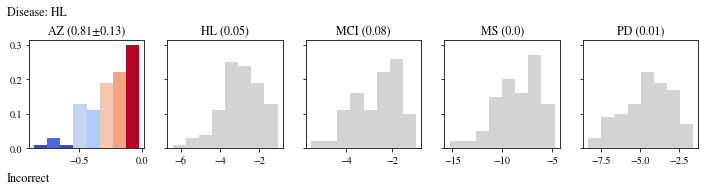

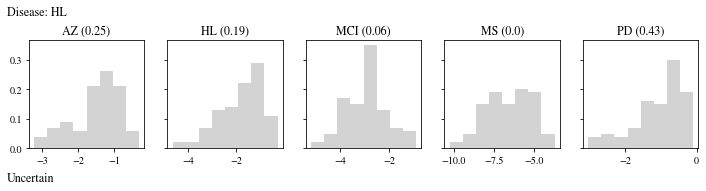

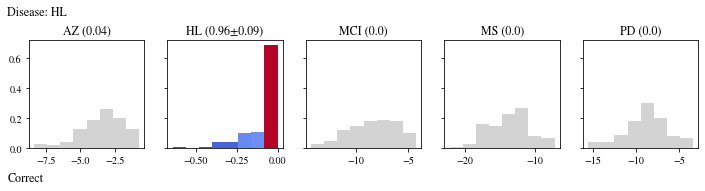

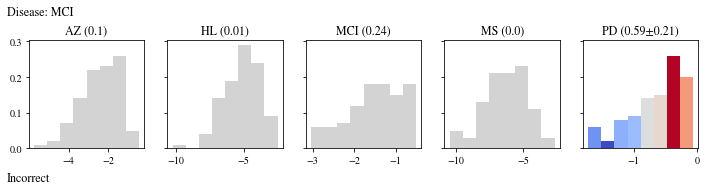

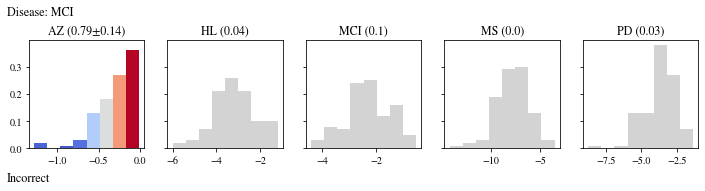

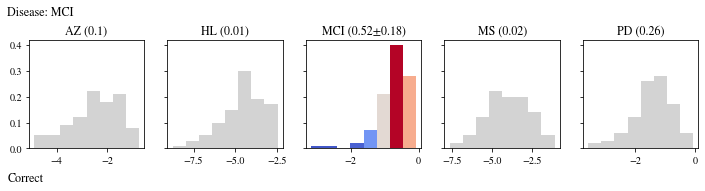

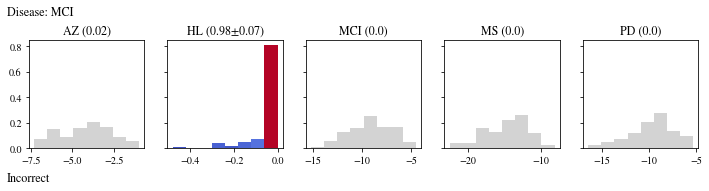

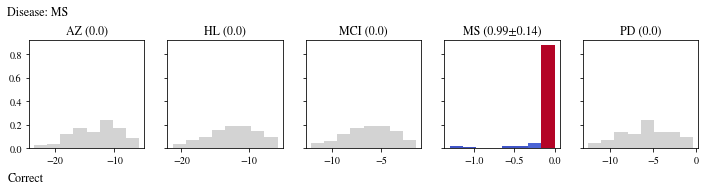

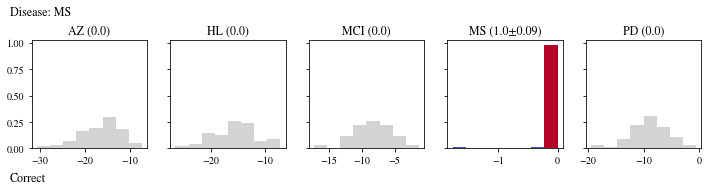

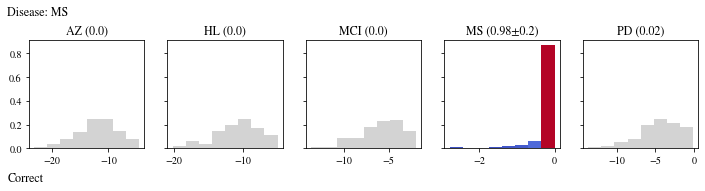

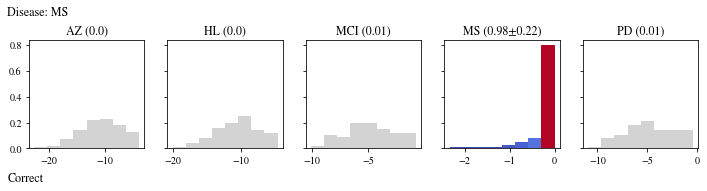

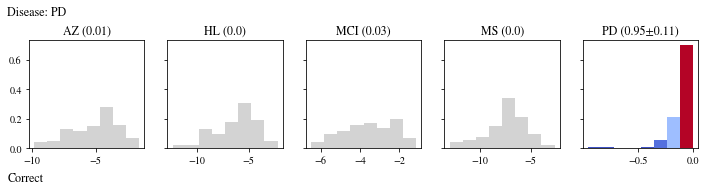

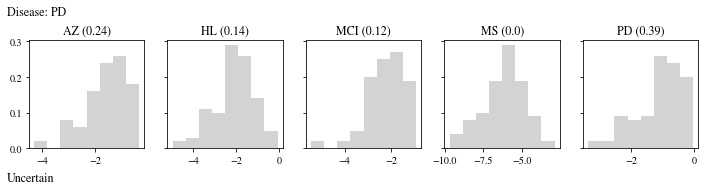

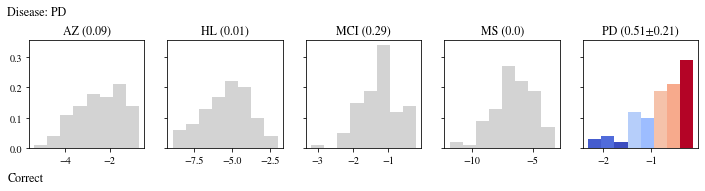

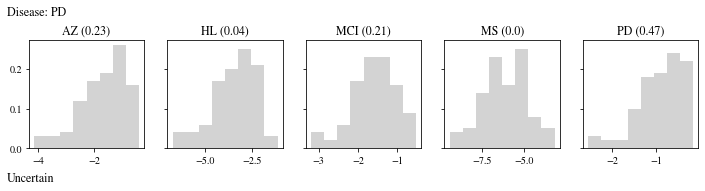

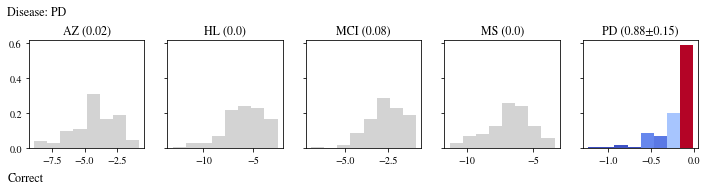

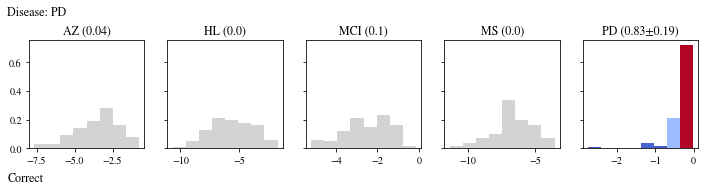

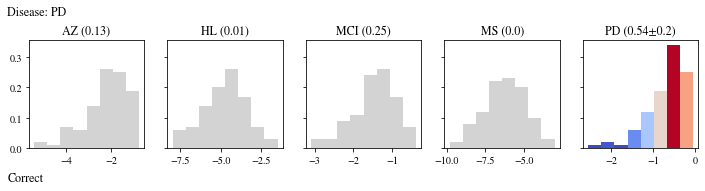

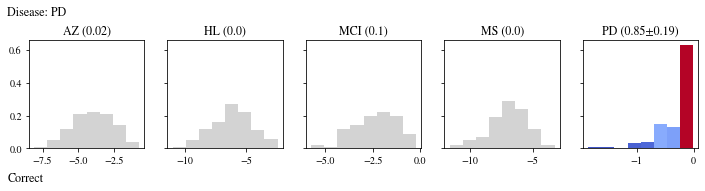

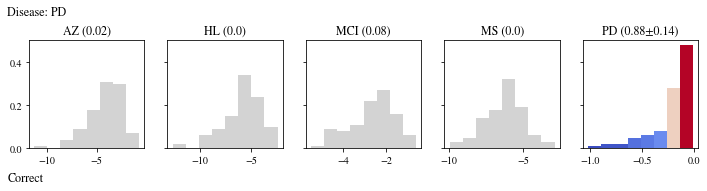

In [ ]:
for prob in range(len(y_probas)):
  y_proba = y_probas[prob]
  y_real = y_reals[prob]
  plot_uncertainities(y_proba, y_real, iterations)

### Uncertainties per class

In [ ]:
labels_reales = np.argmax(labels_data['val'], axis =1)

In [ ]:
x = np.where(labels_reales[:-1] != labels_reales[1:])[0]
x = x + 1
x = np.append(x,[len(labels_reales)])
x

array([ 9, 31, 35, 39, 48])

In [ ]:
initial = 0
classes = ['AZ','Healthy','MCI','MS','PD']
means_dict = dict()
std_dict = dict()


for value, d in zip(range(len(x)), classes):
  last = x[value]
  class_data = [i for i in range(initial, last)]

  y_probas , y_means , y_stds, y_reals = probabilities(class_data, 100)

  mean_class = np.array([y_means[i][0,value] for i in range(len(y_means))])
  std_class =  np.array([y_stds[i][0,value] for i in range(len(y_stds))])

  means_dict[d] = mean_class
  std_dict[d] = std_class

  initial = x[value]

In [ ]:
dis = 'MS'
means_dict[dis]
#means_dict[dis] = np.where(means_dict[dis] > 0.9,means_dict[dis] + 0.05, means_dict[dis])

array([0.9253022 , 0.93157166, 0.94925267, 0.9909965 ], dtype=float32)

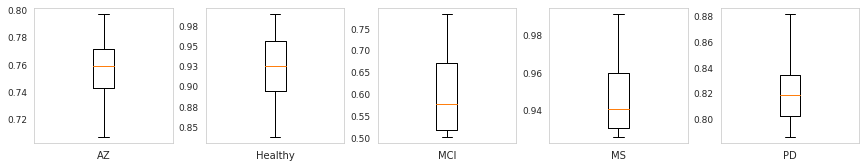

In [ ]:
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

fig, axs = plt.subplots(1, 5, figsize=(12,2.3))
diseases = ['AZ','Healthy','MCI','MS','PD']

for d in range(0,len(diseases)):
  axs[d].boxplot(means_dict[diseases[d]])
  axs[d].set_xticklabels((diseases[d],))
  axs[d].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  axs[d].tick_params(axis='y', labelsize=9)
  axs[d].grid(False)

fig.tight_layout(pad=0.6)


In [ ]:
def mean_confidence_interval(data, confidence=0.95):
       a = 1.0*np.array(data)
       n = len(a)
       m, se = np.mean(a), scipy.stats.sem(a)
       h = se * scipy.stats.t._ppf((1+confidence)/2., n-1)
       return m, m-h, m+h

In [ ]:
SE = (0.734 - 0.778)/(scipy.stats.t._ppf((1+0.95)/2., 4-1))
me = 0.734 - SE*(scipy.stats.t._ppf((1+0.95)/2., 9-1))
print(SE, me)

-0.01908062493537693 0.778


In [ ]:
for d in range(0,len(diseases)):
  m, m_pos , m_neg = mean_confidence_interval(means_dict[diseases[d]])
  print(diseases[d] + ': (' + str(round(m_pos,3)) + ',' + str(round(m_neg,3)) + ')')

AZ: (0.734,0.778)
Healthy: (0.903,0.943)
MCI: (0.406,0.813)
MS: (0.902,0.996)
PD: (0.8,0.85)


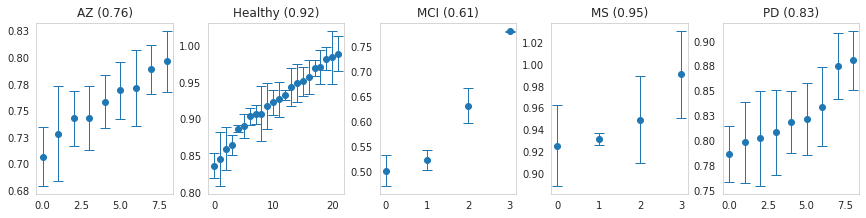

In [ ]:
fig, axs = plt.subplots(1, 5,figsize=(12,3))
diseases = ['AZ','Healthy','MCI','MS','PD']

for d in range(0,len(diseases)):
    mean = np.array(means_dict[diseases[d]])
    std  = np.array(std_dict[diseases[d]])

    axs[d].set_title( diseases[d] + " (" + str(round(np.mean(mean),2)) + ")")
    axs[d].errorbar(x = range(0,len(means_dict[diseases[d]])), y = mean, yerr=2*std/10, fmt='o',capsize=5, elinewidth=1, markeredgewidth=1)
    axs[d].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    axs[d].grid(False)


fig.tight_layout(pad=0.6)

### Weights Distributions

In [ ]:
model.load_weights("3DCNN-Seg-Bayesian-Repara-AZ1.h5")

In [ ]:
tf.compat.v1.enable_eager_execution()
k_names = []
k_qmeans = []
k_qstds = []
for i, layer in enumerate(model.layers):
  try:
    q = layer.kernel_posterior
  except AttributeError:
    continue
  k_names.append("Layer {}".format(i))
  k_qmeans.append(q.mean())
  k_qstds.append(q.stddev())

In [ ]:
tf.compat.v1.enable_eager_execution()
b_names = []
b_qmeans = []
b_qstds = []
for i, layer in enumerate(model.layers):
  try:
    q = layer.bias_posterior
  except AttributeError:
    continue
  b_names.append("Layer {}".format(i))
  b_qmeans.append(q.mean())
  b_qstds.append(q.stddev())

In [ ]:
names = ['Initial Layer', 'Final Layer']

In [ ]:
from matplotlib import figure
def plot_weight_posteriors(names, qm_vals, qs_vals):
  """Save a PNG plot with histograms of weight means and stddevs.
  Args:
    names: A Python `iterable` of `str` variable names.
    qm_vals: A Python `iterable`, the same length as `names`,
      whose elements are Numpy `array`s, of any shape, containing
      posterior means of weight varibles.
    qs_vals: A Python `iterable`, the same length as `names`,
      whose elements are Numpy `array`s, of any shape, containing
      posterior standard deviations of weight varibles.
    fname: Python `str` filename to save the plot to.
  """
  fig = figure.Figure(figsize=(12, 4))

  ax = fig.add_subplot(1, 2, 1)
  for n, qm in zip(names, qm_vals):
    sns.distplot(np.array(qm).flatten(), ax=ax, label=n)
  ax.set_title("weight means")
  ax.set_xlim([-0.5, 0.5])
  ax.legend()

  ax = fig.add_subplot(1, 2, 2)
  for n, qs in zip(names, qs_vals):
    sns.distplot(np.array(qs).flatten(), ax=ax)
  ax.set_title("weight stddevs")
  ax.set_xlim([0, 0.2])

  fig.tight_layout()

  return fig


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

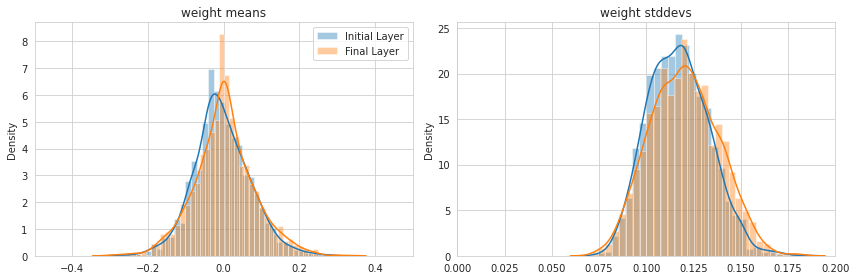

In [ ]:
plot_weight_posteriors(names, k_qmeans, k_qstds)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

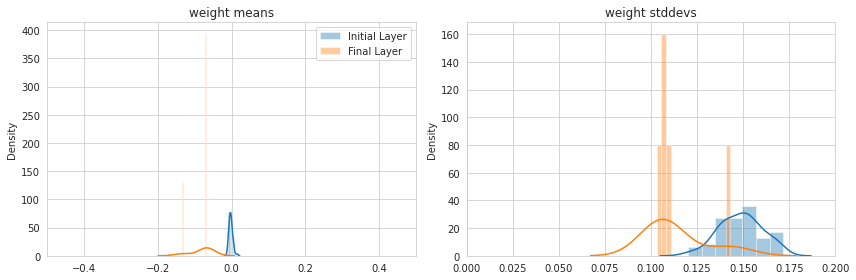

In [ ]:
plot_weight_posteriors(names, b_qmeans, b_qstds)